In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller

sp500 = pd.read_csv('Input_Data/^SPX.csv')
sp500['Date'] = pd.to_datetime(sp500['Date'])

mpd = pd.read_csv('Output_Data/cleaned_feature_engineered_mpd.csv')

In [2]:
# Ensure the 'Date' column in both dataframes is of type datetime64[ns]
# mpd.set_index('Date', inplace=True)
mpd['Date'] = pd.to_datetime(mpd['Date'])  # Since 'Date' is the index for mpd
sp500['Date'] = pd.to_datetime(sp500['Date'])

# mpd_sp500 = pd.merge(mpd, sp500, on='Date', how='left')
mpd_sp500 = pd.merge(mpd, sp500[['Date', 'Adj Close']], on='Date', how='left')

In [3]:
# rename Adj Close to SP_adj_close,
mpd_sp500.rename(columns={'Adj Close': 'SP_adj_close'}, inplace=True)


mpd_sp500['SP_lg_pr'] = np.log(mpd_sp500['SP_adj_close'])

# log returns
mpd_sp500['SP_lg_ret(%)'] = mpd_sp500['SP_lg_pr'].diff() * 100 # in percentage for better visualization

# drop the first row
mpd_sp500 = mpd_sp500[1:]

In [4]:
# print na values   
print(mpd_sp500.isna().sum())

Date                  0
f1_maturity_target    0
f1_mu                 0
f1_sd                 0
f1_skew               0
                     ..
f14_lg_change_incr    0
f14_prInc             0
SP_adj_close          3
SP_lg_pr              3
SP_lg_ret(%)          6
Length: 172, dtype: int64


In [5]:
mpd_sp500 = mpd_sp500.fillna(method='ffill')

### SP500 Log Price Analysis

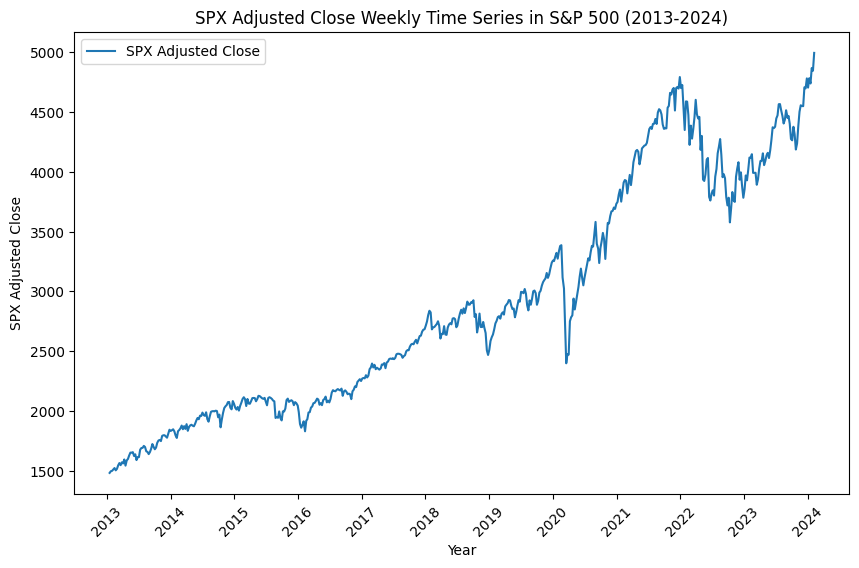

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(mpd_sp500['Date'], mpd_sp500['SP_adj_close'], label='SPX Adjusted Close')

# Set x-axis major ticks to yearly interval and minor ticks to monthly
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
#ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Format x-tick labels as 4-digit year for major ticks and short month name for minor ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

# Rotate and align the tick labels so they look better
plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.xlabel('Year')
plt.ylabel('SPX Adjusted Close')
plt.title('SPX Adjusted Close Weekly Time Series in S&P 500 (2013-2024)')
plt.legend()
plt.show()



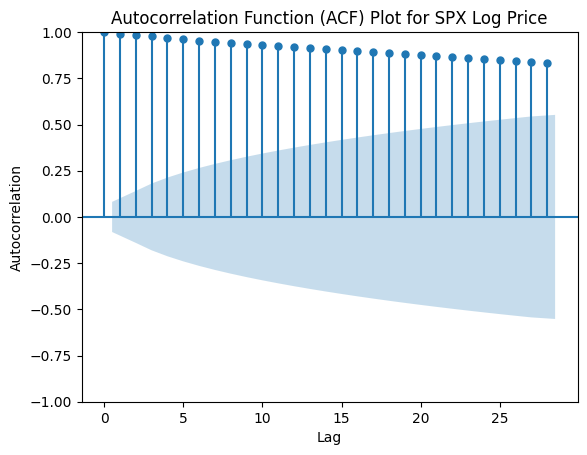

In [7]:
# ACF plot for log return
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(mpd_sp500['SP_lg_pr'].dropna())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot for SPX Log Price')
plt.show()

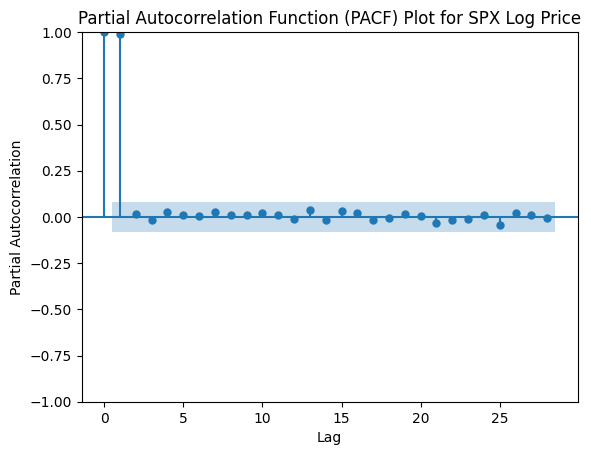

In [8]:
# pacf plot for log return
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(mpd_sp500['SP_lg_pr'].dropna())
# plot_pacf(mpd_sp500['SP_lg_pr'].dropna(), lags=range(1, len(mpd_sp500['SP_lg_pr'].dropna())))
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) Plot for SPX Log Price')
plt.show()


In [9]:
# Calculate the log of the adjusted closing prices for mpd_sp500
mpd_sp500['SP_lg_pr'] = np.log(mpd_sp500['SP_adj_close'])

# Perform ADF test on log prices for mpd_sp500
logprice_result_mpd = adfuller(mpd_sp500['SP_lg_pr'].dropna())
print('ADF Statistic for weekly S&P500 Log price: %f' % logprice_result_mpd[0])
print('p-value for weekly S&P500 Log price: %f' % logprice_result_mpd[1])


ADF Statistic for weekly S&P500 Log price: -0.737745
p-value for weekly S&P500 Log price: 0.836729


- p-value greater than 0.05, do not reject the null hypothesis and conclude the log price is non-stationary. Need to take the differential for further stationarity test
- The ACF plot does not decay also means non-stationary

### SP500 Log Return Analysis

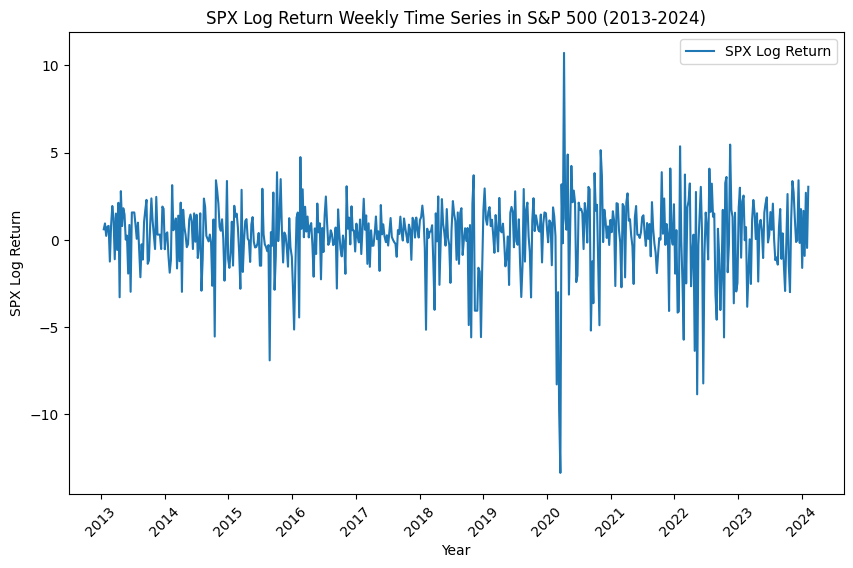

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(mpd_sp500['Date'], mpd_sp500['SP_lg_ret(%)'], label='SPX Log Return')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.xlabel('Year')
plt.ylabel('SPX Log Return')
plt.title('SPX Log Return Weekly Time Series in S&P 500 (2013-2024)')
plt.legend()
plt.show()

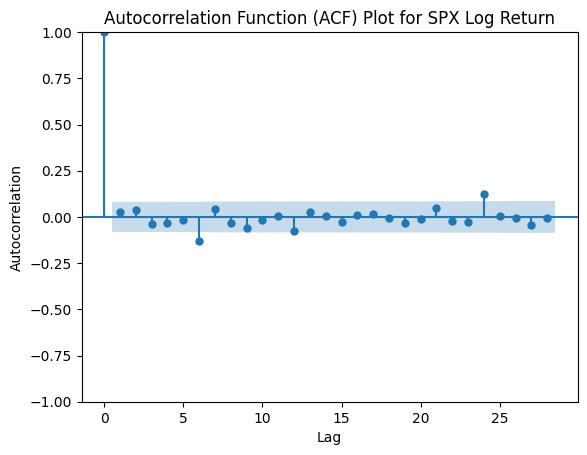

In [11]:
# ACF plot for log return
plot_acf(mpd_sp500['SP_lg_ret(%)'].dropna())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot for SPX Log Return')
plt.show()

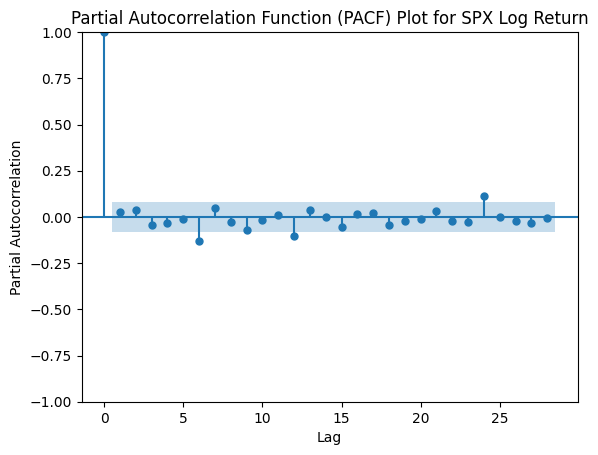

In [12]:
# pacf plot for log return

plot_pacf(mpd_sp500['SP_lg_ret(%)'].dropna())
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) Plot for SPX Log Return')
plt.show()

**Discovery from the ACF and PACF Plots**
1. ACF and PACF plots shows the the log price of SPX has no significant serial correlation. It aligns with the Efficient Market Hypothesis.
2. This variable has the volatility clustering feature (Variance Dependent).
    - Given the stationary feature of log-return, the corresponding time series plot shows that large changes in prices tend to be followed by larged changed (whether up or down) and small change tend ot be followed by small changes. It illustrates that variance (risk or volatility) is not constant over time but exhibit dependencies.
3. Due to the feature of Volatiltiy Clustering of SPX log return, two models should be constructed:
    - Return Model
    - Volatility Model

In [13]:
# Perform ADF test for the log return of mpd_sp500
logreturn_result_mpd = adfuller(mpd_sp500['SP_lg_ret(%)'].dropna())
print('ADF Statistic for weekly S&P500 Log Return: %f' % logreturn_result_mpd[0])
print('p-value for weekly S&P500 Log Return: %f' % logreturn_result_mpd[1])

ADF Statistic for weekly S&P500 Log Return: -11.384808
p-value for weekly S&P500 Log Return: 0.000000


- If the ADF statistic is less than the critical value, we reject the null hypothesis and conclude that the series is stationary.
- A low p-value (typically less than 0.05) also indicates stationarity.

In [14]:
VIX = pd.read_csv('Input_Data/^VIX.csv')
VIX['Date'] = pd.to_datetime(VIX['Date'])
# remove the Open, High, Low, Close, and Volume columns
VIX = VIX[['Date', 'Adj Close']]
# devide the VIX by 100
VIX['Adj Close'] = VIX['Adj Close'] / 100
# rename the Adj Close to VIX
VIX.rename(columns={'Adj Close': 'VIX'}, inplace=True)

# merge the VIX with mpd_sp500
mpd_sp500_VIX = pd.merge(mpd_sp500, VIX, on='Date', how='left')
mpd_sp500_VIX.head()

,Date,f1_maturity_target,f1_mu,f1_sd,f1_skew,f1_kurt,f1_p10,f1_p50,f1_p90,f1_lg_change_decr,...,f14_p50,f14_p90,f14_lg_change_decr,f14_prDec,f14_lg_change_incr,f14_prInc,SP_adj_close,SP_lg_pr,SP_lg_ret(%),VIX
0,2013-01-17,3.0,-0.00364,0.15922,-0.25881,0.50275,-0.20880,0.00419,0.18737,-20.0,...,0.00280,0.06621,-10.0,0.03761,10.0,0.02347,1480.939941,7.300432,0.597345,0.1357
1,2013-01-24,3.0,-0.00801,0.15337,-0.57865,1.03350,-0.21009,0.00958,0.16336,-20.0,...,0.00258,0.06933,-10.0,0.04333,10.0,0.03237,1494.819946,7.309761,0.932878,0.1269
2,2013-01-31,3.0,-0.00801,0.15337,-0.57865,1.03350,-0.21009,0.00958,0.16336,-20.0,...,0.00258,0.06933,-10.0,0.04333,10.0,0.03237,1498.109985,7.311960,0.219854,0.1428
3,2013-02-07,3.0,-0.00430,0.15325,-0.34592,0.64703,-0.19913,0.00299,0.18027,-20.0,...,0.00383,0.07824,-10.0,0.05847,10.0,0.05089,1509.390015,7.319461,0.750130,0.1350
4,2013-02-14,3.0,-0.00430,0.15325,-0.34592,0.64703,-0.19913,0.00299,0.18027,-20.0,...,0.00383,0.07824,-10.0,0.05847,10.0,0.05089,1521.380005,7.327373,0.791222,0.1266


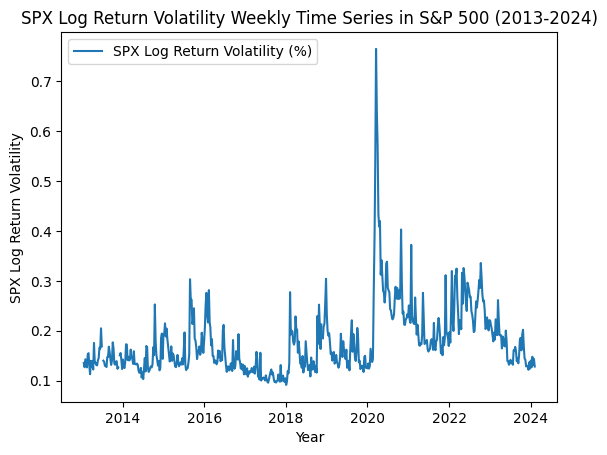

In [15]:
# plot the volatility of the log return by using (return - mean)^2 
#mpd_sp500['SP_lg_ret_vol'] = (mpd_sp500['SP_lg_ret'] - mpd_sp500['SP_lg_ret'].mean())**2
plt.plot(mpd_sp500_VIX['Date'], mpd_sp500_VIX['VIX'], label='SPX Log Return Volatility (%)')
plt.xlabel('Year')
plt.ylabel('SPX Log Return Volatility')
plt.title('SPX Log Return Volatility Weekly Time Series in S&P 500 (2013-2024)')
plt.legend()
plt.show()


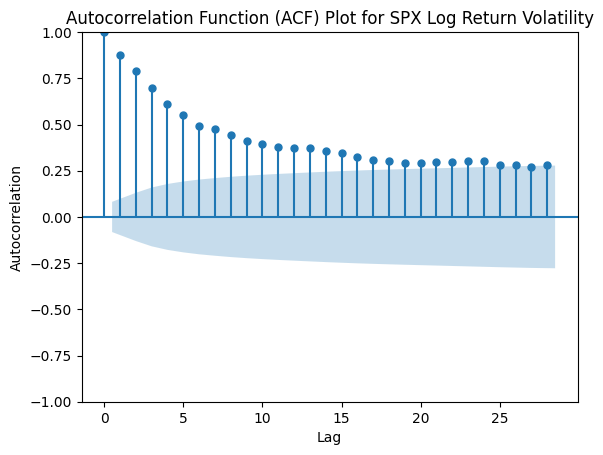

In [16]:
# ACF plot for log return volatility
plot_acf(mpd_sp500_VIX['VIX'].dropna())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot for SPX Log Return Volatility')
plt.show()

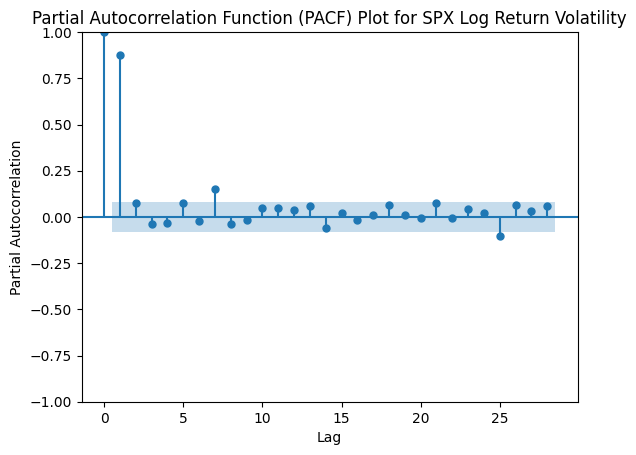

In [17]:
# pacf plot for log return volatility
plot_pacf(mpd_sp500_VIX['VIX'].dropna())
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) Plot for SPX Log Return Volatility')
plt.show()

The ACF and PACF plots for the SPX log return volatility shows certain level of serial relationship compared with those of SPX log return itself.

In [18]:
import pandas as pd

# Assuming mpd_sp500_VIX is your dataframe that's already defined

# Calculate descriptive statistics
describe_stats = mpd_sp500_VIX[['SP_lg_pr', 'SP_lg_ret(%)', 'VIX']].describe()

# Calculate skewness and kurtosis, and convert them to DataFrame for easy concatenation
skewness = mpd_sp500_VIX[['SP_lg_pr', 'SP_lg_ret(%)', 'VIX']].skew().to_frame('Skewness')
kurtosis = mpd_sp500_VIX[['SP_lg_pr', 'SP_lg_ret(%)', 'VIX']].kurt().to_frame('Kurtosis')

# Concatenate all statistics
# Note: We're converting skewness and kurtosis to dataframes to match the structure of describe_stats
all_stats = pd.concat([describe_stats, skewness.T, kurtosis.T])

# Select only the rows we're interested in to match your desired output
summary_stats = all_stats.loc[['mean', 'std', 'min', 'max', 'Skewness', 'Kurtosis']]

# Transpose the result for the format you want
summary_stats = summary_stats.T

# Display the formatted summary statistics
summary_stats


,mean,std,min,max,Skewness,Kurtosis
SP_lg_pr,7.921038,0.329224,7.300432,8.516205,0.103323,-1.221538
SP_lg_ret(%),0.195893,2.139886,-13.378460,10.717307,-1.152709,5.581376
VIX,0.176717,0.069684,0.091500,0.764500,2.816193,14.741853


In [19]:
# export the dataframe to csv
mpd_sp500_VIX.to_csv('Output_Data/mpd_sp500.csv', index=False)